## Process and Save DICOM Datasets for All Subjects
### remove line-like components from the image, load DICOM series, save the dataset

In [32]:
import os
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from pydicom.errors import InvalidDicomError
from skimage import measure, color
from skimage.filters import threshold_otsu
from skimage import morphology

# Preprocessing function to remove line-like components from the image
def remove_lines_from_image(grayscale_image):
    # Step 1: Binarize the grayscale image using Otsu's thresholding
    threshold_value = threshold_otsu(grayscale_image)
    binary_image = grayscale_image > threshold_value

    # Step 2: Label connected components
    labels = measure.label(binary_image, connectivity=2)

    # Step 3: Measure properties of each connected component
    regions = measure.regionprops(labels)

    # Step 4: Create an empty mask to store filtered components (lines/curves at the bottom)
    filtered_mask = np.zeros(labels.shape, dtype=np.uint8)

    # Define the cutoff for the "bottom" part of the image (e.g., bottom third of the image)
    bottom_threshold = int(labels.shape[0] * 2 / 3)

    # Step 5: Filter components based on eccentricity, area, and position in the image
    for region in regions:
        if region.eccentricity > 0.9 and 50 < region.area < 5000:
            centroid_y = region.centroid[0]
            if centroid_y > bottom_threshold:
                filtered_mask[labels == region.label] = 255

    # Step 6: Remove the detected lines/curves from the original grayscale image
    # Create a copy of the original image to modify
    modified_image = grayscale_image.copy()

    # Set the pixels where filtered_mask is 255 (detected lines) to black (0)
    modified_image[filtered_mask == 255] = 0

    return modified_image


def apply_lung_mask(grayscale_image):
    """
    Applies a mask to keep only the lung region and sets everything outside to black (0).
    """
    # Step 1: Apply Otsu's thresholding to binarize the image
    threshold_value = threshold_otsu(grayscale_image)
    binary_image = grayscale_image > threshold_value

    # Step 2: Label connected components
    labels = measure.label(binary_image, connectivity=2)

    # Step 3: Measure properties of each connected component
    regions = measure.regionprops(labels)

    # Step 4: Find the largest connected component, assuming it represents the lung
    largest_region = max(regions, key=lambda r: r.area)

    # Step 5: Create a mask that keeps only the largest connected component
    lung_mask = np.zeros(labels.shape, dtype=np.uint8)
    lung_mask[labels == largest_region.label] = 1  # Set pixels of the largest region (lung) to 1

    # Step 6: Morphological operations to fill holes inside the lung mask
    lung_mask_filled = morphology.binary_closing(lung_mask, morphology.disk(5))  # Fill small holes

    # Step 7: Apply the mask to the original image
    # Set everything outside the lung region to black (0), keep inside lung unchanged
    masked_image = grayscale_image.copy()
    masked_image[lung_mask_filled == 0] = 0  # Set everything outside lung to black (0)

    return masked_image

# Function to load DICOM series
def load_dicom_series(directory):
    dicom_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.dcm') and not f.startswith('._')]
    dicom_files.sort()  # Sort the files to ensure the correct order
    slices = []
    for dcm in dicom_files:
        try:
            dicom_data = pydicom.dcmread(dcm)
            slices.append(dicom_data.pixel_array)
        except InvalidDicomError:
            print(f"Skipping non-DICOM file: {dcm}")
            continue
        except AttributeError:
            print(f"File does not contain pixel data: {dcm}")
            continue
    if not slices:
        raise ValueError(f"No valid DICOM images found in directory: {directory}")
    images = np.stack(slices)
    return images

# Function to find the correct directory based on a keyword
def find_directory(base_path, subject_folder, keyword):
    for root, dirs, files in os.walk(os.path.join(base_path, subject_folder)):
        for dir_name in dirs:
            if keyword in dir_name:
                return os.path.join(root, dir_name)
    raise FileNotFoundError(f"Directory containing '{keyword}' not found in {subject_folder}")

# Function to load subject data and apply preprocessing
def load_subject_data(base_path, subject):
    # Find and load high-dose reconstructed image
    high_dose_img_dir = find_directory(base_path, subject, "Full Dose Images")
    high_dose_img = load_dicom_series(high_dose_img_dir)

    # Preprocess high-dose images by removing line-like components and applying lung mask
    high_dose_img_processed = np.array([apply_lung_mask(remove_lines_from_image(img)) for img in high_dose_img])
    

    # Find and load low-dose reconstructed image
    low_dose_img_dir = find_directory(base_path, subject, "Low Dose Images")
    low_dose_img = load_dicom_series(low_dose_img_dir)

    # Preprocess low-dose images by removing line-like components and applying lung mask
    low_dose_img_processed = np.array([apply_lung_mask(remove_lines_from_image(img)) for img in low_dose_img])


    return high_dose_img_processed, low_dose_img_processed

# Function to save the dataset
def save_dataset(base_path, subject, high_dose_img, low_dose_img):
    # Create a dictionary to store the dataset
    dataset = {
        'high_dose_img': high_dose_img,
        'low_dose_img': low_dose_img
    }

    # Define the filename for the dataset
    filename = os.path.join(base_path, f"{subject}_dataset.npz")
    
    # Save the dataset as a .npz file
    np.savez_compressed(filename, **dataset)
    print(f"Dataset saved to {filename}")

# Function to process all subjects
def process_all_subjects(base_path):
    # List all subject folders in the base directory
    for subject in os.listdir(base_path):
        subject_path = os.path.join(base_path, subject)
        if os.path.isdir(subject_path):  # Check if it is a directory
            # Define the filename for the dataset
            dataset_filename = os.path.join(base_path, f"{subject}_dataset.npz")
            
            # Check if the dataset file already exists
            if os.path.exists(dataset_filename):
                print(f"Dataset already exists for subject: {subject}. Skipping.")
                continue  # Skip processing this subject
            
            try:
                print(f"Processing subject: {subject}")
                high_dose_img, low_dose_img = load_subject_data(base_path, subject)
                save_dataset(base_path, subject, high_dose_img, low_dose_img)
            except Exception as e:
                print(f"Error processing subject {subject}: {e}")

if __name__ == "__main__":
    base_path = "dataset"  # Path to the dataset directory
    process_all_subjects(base_path)


Processing subject: C001
Error processing subject C001: Directory containing 'Low Dose Images' not found in C001
Processing subject: C002
Dataset saved to dataset\C002_dataset.npz
Processing subject: C004
Dataset saved to dataset\C004_dataset.npz
Processing subject: C009
Error processing subject C009: Directory containing 'Low Dose Images' not found in C009
Processing subject: C012
Dataset saved to dataset\C012_dataset.npz
Processing subject: C016
Dataset saved to dataset\C016_dataset.npz
Processing subject: C019
Error processing subject C019: Directory containing 'Low Dose Images' not found in C019
Processing subject: C021
Dataset saved to dataset\C021_dataset.npz
Processing subject: C023
Error processing subject C023: Directory containing 'Low Dose Images' not found in C023
Processing subject: C027
Dataset saved to dataset\C027_dataset.npz
Processing subject: C030
Dataset saved to dataset\C030_dataset.npz
Processing subject: C031
Error processing subject C031: Directory containing 'L

## Verify Image Sizes Across All Datasets

In [33]:
import os
import numpy as np

def load_dataset(file_path):
    # Load the dataset from the .npz file
    with np.load(file_path) as data:
        high_dose_img = data['high_dose_img']
        low_dose_img = data['low_dose_img']
    return high_dose_img, low_dose_img

def check_image_sizes(images, expected_size=(512, 512)):
    # Check that all images in the dataset have the expected size
    for i, img in enumerate(images):
        if img.shape != expected_size:
            print(f"Image {i} does not have the expected size {expected_size}: {img.shape}")

def check_all_datasets(base_path):
    # List all .npz files in the base directory
    for file_name in os.listdir(base_path):
        if file_name.endswith('_dataset.npz'):
            file_path = os.path.join(base_path, file_name)
            print(f"Checking dataset: {file_name}")

            try:
                # Load the dataset
                high_dose_img, low_dose_img = load_dataset(file_path)

                # Check that all images have the expected size
                print(f"Checking high-dose images in {file_name}...")
                check_image_sizes(high_dose_img)

                print(f"Checking low-dose images in {file_name}...")
                check_image_sizes(low_dose_img)

            except Exception as e:
                print(f"Error loading or checking dataset {file_name}: {e}")

if __name__ == "__main__":
    base_path = "dataset"  # Path where the .npz files are stored
    check_all_datasets(base_path)


Checking dataset: C002_dataset.npz
Checking high-dose images in C002_dataset.npz...
Checking low-dose images in C002_dataset.npz...
Checking dataset: C004_dataset.npz
Checking high-dose images in C004_dataset.npz...
Checking low-dose images in C004_dataset.npz...
Checking dataset: C012_dataset.npz
Checking high-dose images in C012_dataset.npz...
Checking low-dose images in C012_dataset.npz...
Checking dataset: C016_dataset.npz
Checking high-dose images in C016_dataset.npz...
Checking low-dose images in C016_dataset.npz...
Checking dataset: C021_dataset.npz
Checking high-dose images in C021_dataset.npz...
Checking low-dose images in C021_dataset.npz...
Checking dataset: C027_dataset.npz
Checking high-dose images in C027_dataset.npz...
Checking low-dose images in C027_dataset.npz...
Checking dataset: C030_dataset.npz
Checking high-dose images in C030_dataset.npz...
Checking low-dose images in C030_dataset.npz...
Checking dataset: C077_dataset.npz
Checking high-dose images in C077_dataset

## Validate and Count Images in Datasets

In [34]:
import os
import numpy as np

def load_dataset(file_path):
    # Load the dataset from the .npz file
    with np.load(file_path) as data:
        high_dose_img = data['high_dose_img']
        low_dose_img = data['low_dose_img']
    return high_dose_img, low_dose_img

def check_image_sizes(images, expected_size=(512, 512)):
    # Check that all images in the dataset have the expected size
    for i, img in enumerate(images):
        if img.shape != expected_size:
            print(f"Image {i} does not have the expected size {expected_size}: {img.shape}")

def check_all_datasets(base_path):
    # List all .npz files in the base directory
    for file_name in os.listdir(base_path):
        if file_name.endswith('_dataset.npz'):
            file_path = os.path.join(base_path, file_name)
            print(f"Checking dataset: {file_name}")

            try:
                # Load the dataset
                high_dose_img, low_dose_img = load_dataset(file_path)

                # Count the number of images
                num_high_dose = high_dose_img.shape[0]
                num_low_dose = low_dose_img.shape[0]

                # Print the number of images
                print(f"Number of high-dose images: {num_high_dose}")
                print(f"Number of low-dose images: {num_low_dose}")

                # Check that all images have the expected size
                print(f"Checking high-dose images in {file_name}...")
                check_image_sizes(high_dose_img)

                print(f"Checking low-dose images in {file_name}...")
                check_image_sizes(low_dose_img)

                # Check if the number of images is the same
                if num_high_dose != num_low_dose:
                    print(f"Error: The number of high-dose and low-dose images does not match for {file_name}!")

            except Exception as e:
                print(f"Error loading or checking dataset {file_name}: {e}")

if __name__ == "__main__":
    base_path = "dataset"  # Path where the .npz files are stored
    check_all_datasets(base_path)


Checking dataset: C002_dataset.npz
Number of high-dose images: 280
Number of low-dose images: 280
Checking high-dose images in C002_dataset.npz...
Checking low-dose images in C002_dataset.npz...
Checking dataset: C004_dataset.npz
Number of high-dose images: 361
Number of low-dose images: 361
Checking high-dose images in C004_dataset.npz...
Checking low-dose images in C004_dataset.npz...
Checking dataset: C012_dataset.npz
Number of high-dose images: 351
Number of low-dose images: 351
Checking high-dose images in C012_dataset.npz...
Checking low-dose images in C012_dataset.npz...
Checking dataset: C016_dataset.npz
Number of high-dose images: 319
Number of low-dose images: 319
Checking high-dose images in C016_dataset.npz...
Checking low-dose images in C016_dataset.npz...
Checking dataset: C021_dataset.npz
Number of high-dose images: 378
Number of low-dose images: 378
Checking high-dose images in C021_dataset.npz...
Checking low-dose images in C021_dataset.npz...
Checking dataset: C027_da

## Visualize Sample Images from a Dataset

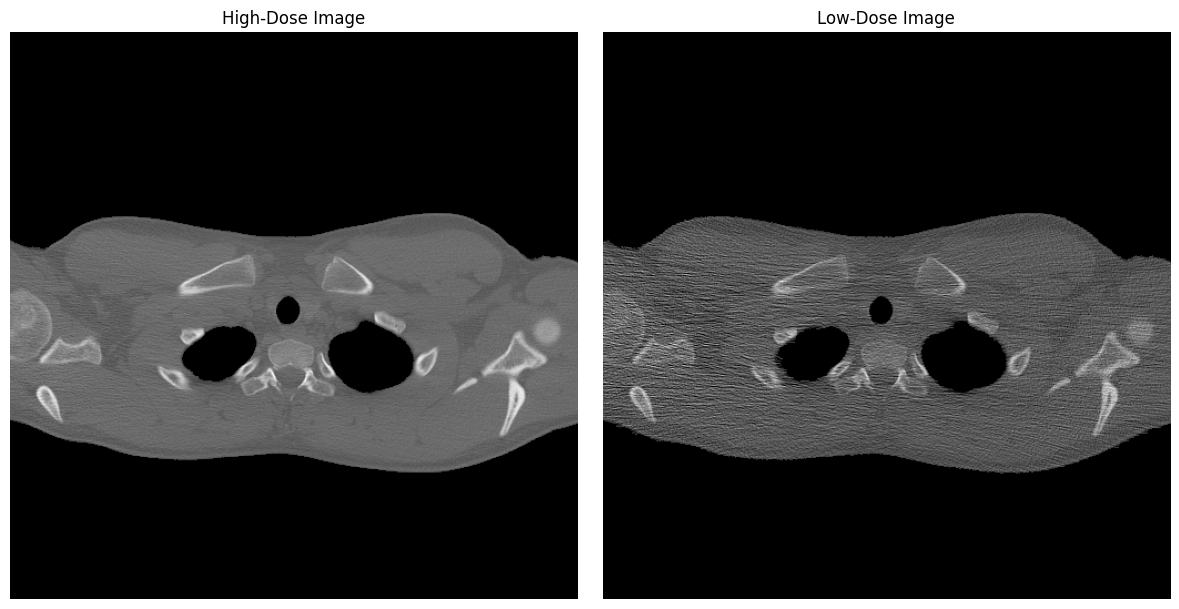

In [35]:
import os
import numpy as np
import matplotlib.pyplot as plt

def load_dataset(file_path):
    # Load the dataset from the .npz file
    with np.load(file_path) as data:
        high_dose_img = data['high_dose_img']
        low_dose_img = data['low_dose_img']
    return high_dose_img, low_dose_img

def plot_sample_pair(high_dose_img, low_dose_img, num_of_image : int):
    # Ensure there is at least one image in each dataset
    if high_dose_img.shape[0] == 0 or low_dose_img.shape[0] == 0:
        print("Error: One of the datasets is empty.")
        return

    # Plot the first image from each dataset
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot high-dose reconstructed image
    axes[0].imshow(high_dose_img[num_of_image], cmap='gray')
    axes[0].set_title('High-Dose Image')
    axes[0].axis('off')

    # Plot low-dose reconstructed image
    axes[1].imshow(low_dose_img[num_of_image], cmap='gray')
    axes[1].set_title('Low-Dose Image')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    base_path = "dataset"  # Path where the .npz files are stored
    subject = "C004"  # Change this to the subject for which the dataset was saved
    file_path = os.path.join(base_path, f"{subject}_dataset.npz")

    # Load the dataset
    high_dose_img, low_dose_img = load_dataset(file_path)

    # Plot one pair of images
    plot_sample_pair(high_dose_img, low_dose_img, num_of_image= 34)

In [12]:
len(high_dose_img)

361

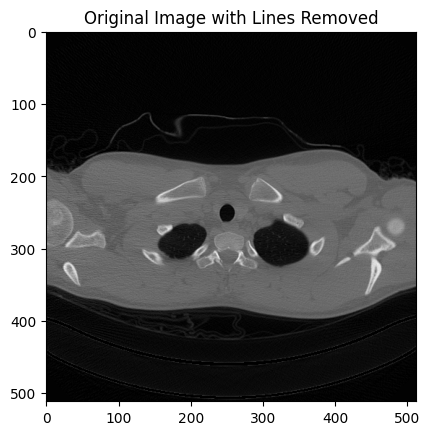

In [29]:
from skimage import measure, color
from skimage.filters import threshold_otsu
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load and binarize the grayscale image using Otsu's thresholding
grayscale_image = high_dose_img[34]
threshold_value = threshold_otsu(grayscale_image)
binary_image = grayscale_image > threshold_value

# Step 2: Label connected components
labels = measure.label(binary_image, connectivity=2)

# Step 3: Measure properties of each connected component
regions = measure.regionprops(labels)

# Step 4: Create an empty mask to store filtered components (lines/curves at the bottom)
filtered_mask = np.zeros(labels.shape, dtype=np.uint8)

# Define the cutoff for the "bottom" part of the image (e.g., bottom third of the image)
bottom_threshold = int(labels.shape[0] * 2 / 3)

# Step 5: Filter components based on eccentricity, area, and position in the image
for region in regions:
    if region.eccentricity > 0.9 and 50 < region.area < 5000:
        centroid_y = region.centroid[0]
        if centroid_y > bottom_threshold:
            filtered_mask[labels == region.label] = 255

# Step 6: Remove the detected lines/curves from the original grayscale image
# Create a copy of the original image to modify
modified_image = grayscale_image.copy()

# Set the pixels where filtered_mask is 255 (detected lines) to black (0)
modified_image[filtered_mask == 255] = 0

# Step 7: Visualize the modified image (with lines removed)
plt.imshow(modified_image, cmap='gray')
plt.title('Original Image with Lines Removed')
plt.show()


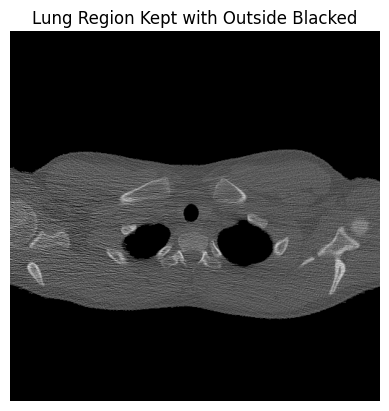

In [30]:
from skimage import measure
from skimage.filters import threshold_otsu
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

# Load the image
grayscale_image = low_dose_img[34]

from skimage import morphology

# Step 1: Apply Otsu's thresholding to binarize the image
threshold_value = threshold_otsu(grayscale_image)
binary_image = grayscale_image > threshold_value

# Step 2: Label connected components
labels = measure.label(binary_image, connectivity=2)

# Step 3: Measure properties of each connected component
regions = measure.regionprops(labels)

# Step 4: Find the largest connected component, assuming it represents the lung
largest_region = max(regions, key=lambda r: r.area)

# Step 5: Create a mask that keeps only the largest connected component
lung_mask = np.zeros(labels.shape, dtype=np.uint8)
lung_mask[labels == largest_region.label] = 1  # Set pixels of the largest region (lung) to 1

# Step 6: Morphological operations to fill holes inside the lung mask
lung_mask_filled = morphology.binary_closing(lung_mask, morphology.disk(5))  # Fill small holes

# Step 7: Apply the mask to the original image
# Set everything outside the lung region to black (0), keep inside lung unchanged
masked_image = grayscale_image.copy()
masked_image[lung_mask_filled == 0] = 1  # Set everything outside lung to black (0)

# Step 8: Visualize the result
plt.imshow(masked_image, cmap='gray')
plt.title('Lung Region Kept with Outside Blacked')
plt.axis('off')
plt.show()

